In [ ]:
import json
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data file was exportm from Zotero in CSL JSON format
with open('data/BIB_saef_20241206.json', 'r') as f:
    bib = json.load(f)

In [3]:
data = {}
for entry in bib:
    doi  = entry['DOI']                                         # Use DOI as key
    saef_author_list    = re.findall('saef:.*', entry['note'])  # Use saef keyword as an identifier

    for names in saef_author_list:
            names_tidy  = re.sub('saef:', '', names, flags=re.IGNORECASE)
            names_split = names_tidy.strip().split(';')         # Create a list of saef names
    
    # retrieve openalex authorship for DOI
    url = f"https://api.openalex.org/works/https://doi.org/{doi}?select=authorships"
    authorships = requests.get(url).json()                      # OpenAlex call using DOI arg
    data[doi] = [names_split, authorships]


In [4]:
# Openalex call retrieving collaboration details
collaboration = []
for combo in data:
    for authors in data[combo][1]['authorships']:
        author = authors['author']['display_name']
        if authors['author']['orcid'] is not None:
            auth_orcid = authors['author']['orcid'].replace("https://orcid.org/", "")
        else:
            auth_orcid = "0000-0000-0000-0000"

        if len(authors['institutions']) > 0:
            auth_inst = authors['institutions'][0]['display_name']
            inst_ctry = authors['institutions'][0]['country_code']
        else:
            auth_inst, inst_ctry = "Missing", "Missing"

        # print(f"{combo}, {data[combo][0]}, {author}, {auth_orcid}, {auth_inst}") # debug print statement
        collaboration.append({"doi": combo, "saef_author":data[combo][0], "collab_author": author, \
                              "collab_orcid":auth_orcid, "collab_inst": auth_inst, "collab_ctry": inst_ctry})

In [5]:
# Collaboration depth
saef_author_collab = {}
for x in collaboration:
    for a in x.get('saef_author'):
        author = a.strip().replace("(", "").replace(")", "")
        # example
        # name = 'LarissaLubianaBotelho'
        # split = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', name)).split() # https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python
        # print(f"{split[0]} {split[-1]}") 
        split = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', author)).split()
        # E.g.  re.search(r'Aleks\w* ?\w*.? Terauds\-?\w*', 'Aleksander Terauds'), re.search(r'Ben\w* ?\w*.? Henley\-?\w*', 'Benjamin A. Henley')
        regex = f"{split[0]}\w* ?\w*.? {split[-1]}\-?\w*" 
        if re.search(regex, x.get('collab_author')):
            pass # name match, don't count as a collaboration. i.e. you cannot collaborate with yourself
        else:
            if author in saef_author_collab:
                saef_author_collab[author].append(f"{x.get('collab_inst')}~{x.get('collab_ctry')}")
            else:
                saef_author_collab[author] = [f"{x.get('collab_inst')}~{x.get('collab_ctry')}"]

# Remove duplicate collaborations per researcher
for entry in saef_author_collab:
    saef_author_collab[entry] = set(saef_author_collab.get(entry))

In [6]:
# breadth of collaboration: Institution & Country
collab_macro = []
for v in saef_author_collab.values():
    for i in v:
        if re.search(r'Missing', i):
            pass
        else:
            collab_macro.append(i.split("~"))

In [7]:

collab_macro_df = pd.DataFrame(collab_macro)
collab_macro_df.columns = ["institution", "country"]


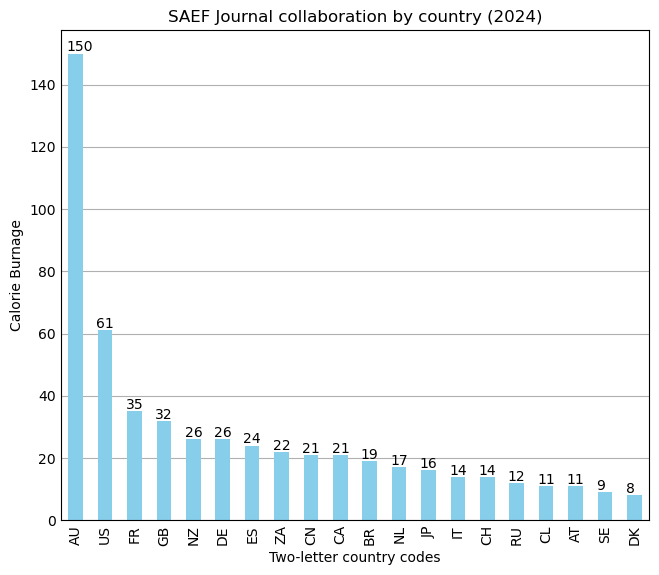

In [ ]:


collab_macro_df['country'].value_counts().head(20).plot(kind="bar", color = "skyblue", figsize=(6, 5))
plt.grid(visible = 0, axis="x")
plt.xlabel("Two-letter country codes")
plt.ylabel("Calorie Burnage")
plt.title("SAEF Journal collaboration by country (2024)")
xlocs, xlabs = plt.xticks()
for i, v in enumerate(collab_macro_df['country'].value_counts().head(20)):
    plt.text(xlocs[i] - 0.3, v + 0.7, str(v), ha = "left")
plt.show()